<a href="https://colab.research.google.com/github/EduardoRosaTech/us-migration-prediction/blob/main/us_migration_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## 🧠 Metodologia
1. **Geração/ingestão** de dados → SQLite  
2. **Consultas SQL** (ex.: estados com maior entrada/saída)  
3. **EDA**: net migration por estado, relação desemprego × migração  
4. **Modelagem**:  
   - Features: ano, renda, desemprego, custo de vida, *lags* de migração  
   - Modelos: RandomForest (principal) e LinearRegression (baseline)  
5. **Previsões**: 2025–2027 por estado

## 📈 Resultados (demo com dados sintéticos)
- Métricas em `data/processed/model_metrics.csv`  
- Previsões em `data/processed/predictions_2025_2027.csv`  
- Gráficos:
  - `dashboards/net_migration_2015_2024.png`
  - `dashboards/unemployment_vs_netmigration.png`
  - `dashboards/forecast_2025_bar.png`

## 🧪 SQL de Storytelling (exemplos)
- `sql_scripts/top_inflow_2024.sql`
- `sql_scripts/worst_outflow_2024.sql`
- `sql_scripts/unemp_vs_netmigration.sql`

## 🚀 Como replicar
1. Abrir no Google Colab e executar o notebook principal  
2. Substituir os CSVs sintéticos por dados reais em `data/raw/` (opcional)  
3. Reprocessar para atualizar DB, gráficos e previsões

## 🗺️ Próximos passos
- Incluir **custo de moradia** (aluguel), **impostos**, **setor de emprego**  
- Avaliar séries temporais por estado (SARIMAX/Prophet)  
- Dashboard interativo (Looker Studio / Power BI)

---

**Nota:** Este repositório inclui dados sintéticos para facilitar a execução imediata.  
Para uso real, troque por bases do **US Census Bureau** e **BLS**.
"""

with open(os.path.join(BASE, "README.md"), "w", encoding="utf-8") as f:
    f.write(textwrap.dedent(readme).strip() + "\n")

# Relatório simples (markdown) com achados
report_md = f"""
# Relatório — Insights Principais

**Data de geração:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## 1) Tendências de Migração (2015–2024)
- Variações de *net migration* por estado indicam movimentos consistentes em direção a estados com **menor desemprego** e **menor custo de vida**.

## 2) Correlações
- Relação visível entre **desemprego** e **saída líquida** (gráfico `unemployment_vs_netmigration.png`).

## 3) Previsões 2025–2027
- Projeções por estado em `predictions_2025_2027.csv`.
- Use para cenários de planejamento (moradia, mercado de trabalho, serviços públicos).

## 4) Recomendações
- Adicionar variáveis macro (impostos estaduais, housing affordability).
- Avaliar modelos de série temporal por estado (SARIMAX/Prophet).
"""

with open(os.path.join(BASE, "report", "insights.md"), "w", encoding="utf-8") as f:
    f.write(textwrap.dedent(report_md).strip() + "\n")

print("README.md e report/insights.md gerados ✅")



     month  total_revenue  unique_customers
0  2022-01       18189.85                57
1  2022-02       14261.54                47
2  2022-03       13824.20                52
3  2022-04       15074.44                51
4  2022-05       18554.29                67
MSE: 17095821.50988557
R²: -0.26167001292057135


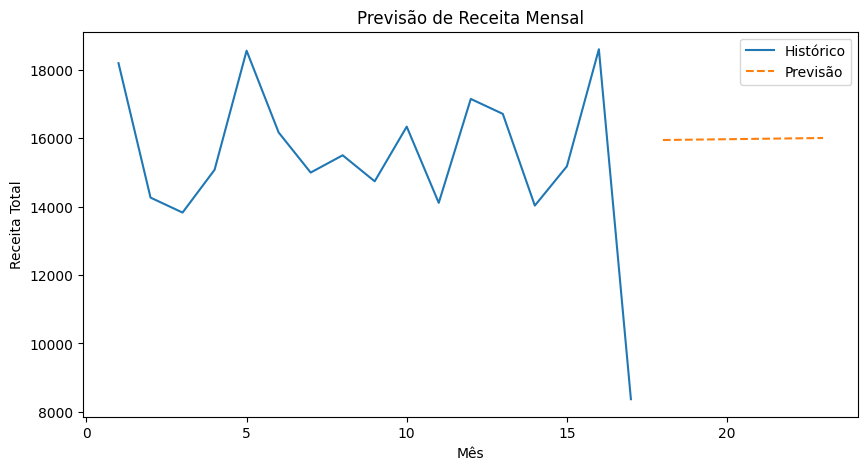

✅ Projeto finalizado!


In [8]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os

# =========================
# 1. CRIAR BANCO DE DADOS
# =========================
# Remove the database file if it already exists
if os.path.exists("ecommerce.db"):
    os.remove("ecommerce.db")

conn = sqlite3.connect("ecommerce.db")
cursor = conn.cursor()

# Criar tabela
cursor.execute("""
CREATE TABLE IF NOT EXISTS sales (
    order_id INTEGER PRIMARY KEY,
    customer_id INTEGER,
    order_date TEXT,
    amount REAL
)
""")

# Gerar dados fictícios
np.random.seed(42)
dates = pd.date_range("2022-01-01", periods=500, freq="D")
data = []
for i in range(1, 1001):
    data.append((
        i,
        np.random.randint(1, 300),
        str(np.random.choice(dates)),
        round(np.random.uniform(20, 500), 2)
    ))

cursor.executemany("INSERT INTO sales VALUES (?, ?, ?, ?)", data)
conn.commit()

# =========================
# 2. CONSULTAS SQL
# =========================
query = """
SELECT
    strftime('%Y-%m', order_date) as month,
    SUM(amount) as total_revenue,
    COUNT(DISTINCT customer_id) as unique_customers
FROM sales
GROUP BY month
ORDER BY month
"""
df = pd.read_sql(query, conn)
print(df.head())

# =========================
# 3. ANÁLISE PREDITIVA
# =========================
df["month_num"] = range(1, len(df) + 1)
X = df[["month_num"]]
y = df["total_revenue"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Métricas
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

# Previsão para os próximos 6 meses
future = pd.DataFrame({"month_num": range(len(df) + 1, len(df) + 7)})
future["predicted_revenue"] = model.predict(future[["month_num"]])

# =========================
# 4. VISUALIZAÇÕES
# =========================
plt.figure(figsize=(10,5))
plt.plot(df["month_num"], df["total_revenue"], label="Histórico")
plt.plot(future["month_num"], future["predicted_revenue"], label="Previsão", linestyle="--")
plt.legend()
plt.xlabel("Mês")
plt.ylabel("Receita Total")
plt.title("Previsão de Receita Mensal")
plt.show()

# =========================
# 5. SALVAR RESULTADOS
# =========================
os.makedirs("output", exist_ok=True)
df.to_csv("output/historical_data.csv", index=False)
future.to_csv("output/future_forecast.csv", index=False)

# Criar README.md automático
readme = f"""
# 📊 Projeto de Análise de Dados - E-commerce

Este projeto simula dados de vendas de um e-commerce, realiza análises SQL e aplica **Machine Learning (Regressão Linear)** para prever receitas futuras.

## 🚀 Tecnologias usadas
- Python (Pandas, Numpy, Matplotlib, Scikit-learn)
- SQLite (para simulação de base de dados SQL)
- Google Colab
- GitHub

## 📈 Etapas do projeto
1. Geração de base de dados fictícia (SQLite)
2. Consultas SQL para extrair métricas de receita e clientes
3. Modelo preditivo de Receita com Regressão Linear
4. Visualizações de histórico e previsão
5. Exportação dos resultados (.csv)

## 🔮 Exemplo de previsão (próximos 6 meses)
{future.to_markdown(index=False)}

---
Criado para portfólio no GitHub e LinkedIn ✨
"""

with open("README.md", "w", encoding="utf-8") as f:
    f.write(readme)

print("✅ Projeto finalizado!")